# RandomForest Classifier Implementation 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [2]:
df = sns.load_dataset('tips')

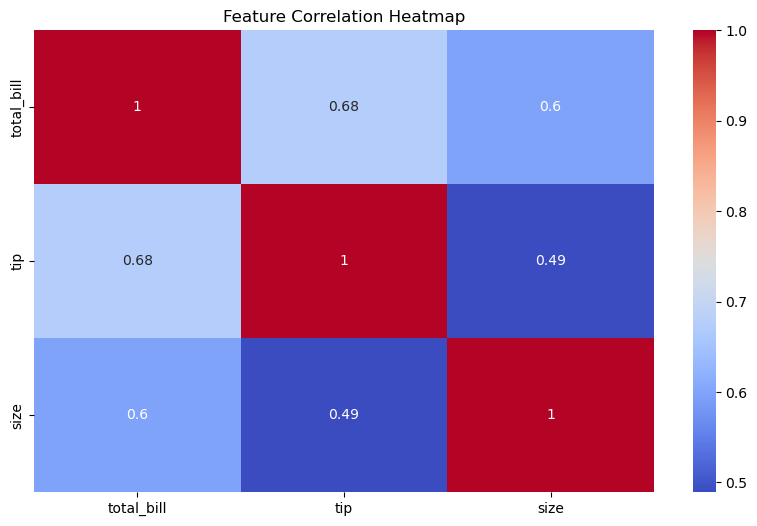

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Preprocessing: Label Encoding for target variable

In [4]:
encoder = LabelEncoder()

In [5]:
df['time'] = encoder.fit_transform(df['time'])

In [6]:
X = df.drop(labels=['time'], axis=1)
y = df['time']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

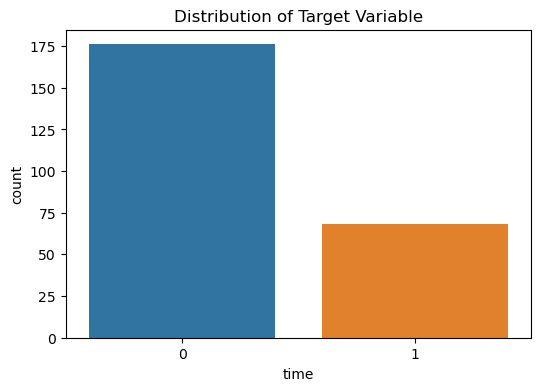

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.show()

## Categorical and numerical feature separation

In [9]:
categorical_cols = ['sex', 'smoker', 'day']
numerical_cols = ['total_bill', 'tip', 'size']

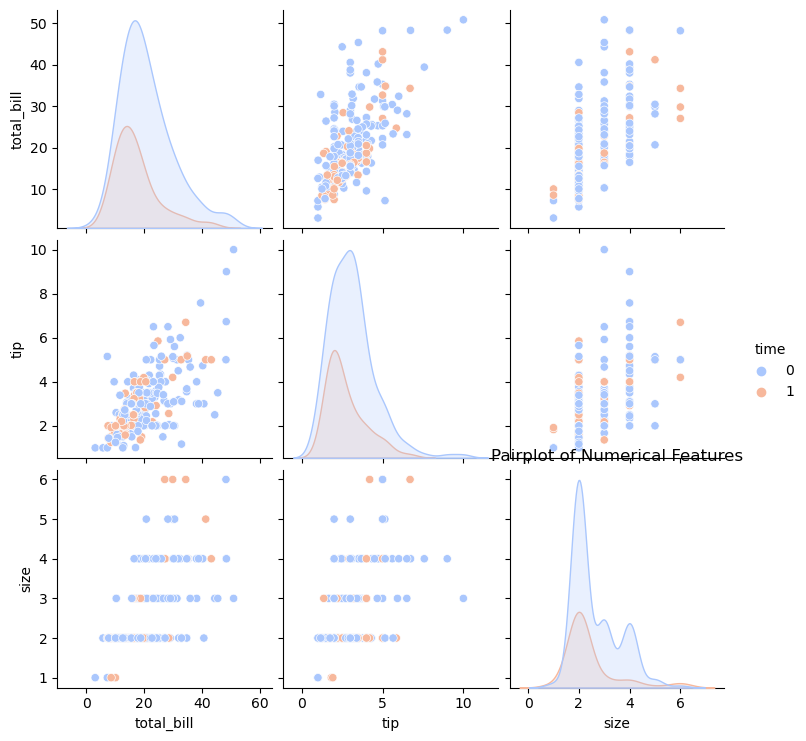

In [10]:
sns.pairplot(df[numerical_cols + ['time']], hue='time', palette='coolwarm')
plt.title('Pairplot of Numerical Features')
plt.show()

## Preprocessing pipelines

In [11]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handling missing values
    ('scaler', StandardScaler())  # Feature scaling
])

In [12]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
    ('onehot', OneHotEncoder())  # One-hot encoding categorical features
])

In [13]:
# Combining both pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

In [14]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Model dictionary for evaluating multiple models

In [15]:
models = {
    'Random Forest': RandomForestClassifier(),
}

In [16]:
def evaluate_model(X_train, y_train, X_test, y_test, models):
    report = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Model: {model_name}\n")
        print(classification_report(y_test, y_pred))
        report[model_name] = acc
    return report

In [17]:
def plot_confusion_matrix_and_roc(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    cm = confusion_matrix(y_test, y_pred)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f"Confusion Matrix for {model_name}")
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    if y_prob is not None:
        ax2.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_title(f'ROC Curve for {model_name}')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()
    plt.tight_layout()
    plt.show()

In [18]:
# Evaluate models
model_scores = evaluate_model(X_train, y_train, X_test, y_test, models)

Model: Random Forest

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.88      1.00      0.94        15

    accuracy                           0.96        49
   macro avg       0.94      0.97      0.95        49
weighted avg       0.96      0.96      0.96        49



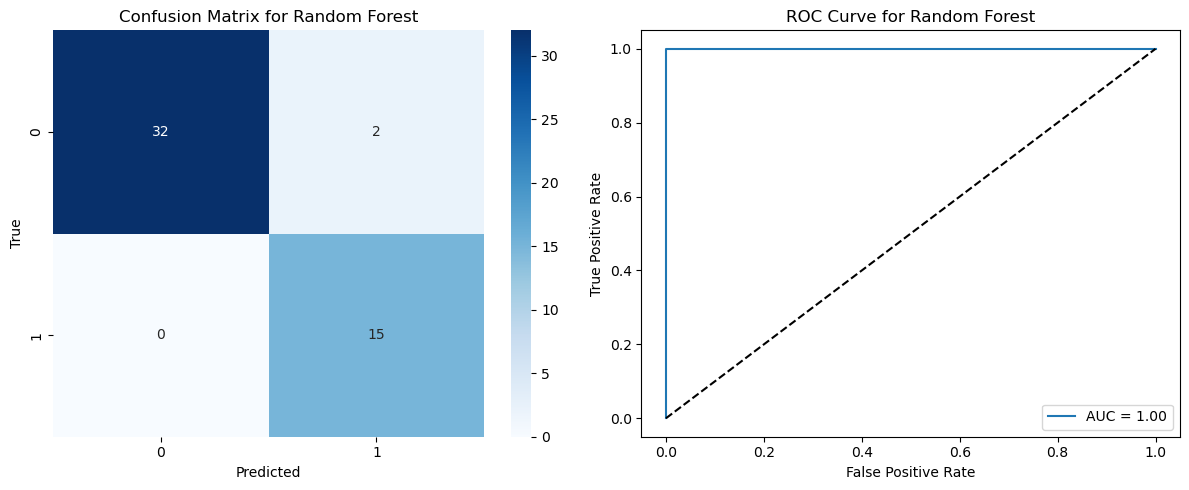

In [19]:
plot_confusion_matrix_and_roc(models['Random Forest'], X_test, y_test, 'Random Forest')

## Hyperparameter tuning for RandomForest

In [20]:
params = {
    'max_depth': [3, 5, 10, None],
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy']
}

## Randomized Search for Hyperparameter Tuning

In [21]:
classifier = RandomForestClassifier(random_state=42)

In [22]:
cv = RandomizedSearchCV(estimator=classifier, param_distributions=params, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)

In [23]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy', verbose=3)

In [24]:
print("Best parameters found: ", cv.best_params_)

Best parameters found:  {'n_estimators': 300, 'max_depth': 3, 'criterion': 'gini'}


In [25]:
y_pred_cv = cv.predict(X_test)

In [26]:
print("Tuned Model Accuracy: ", accuracy_score(y_test, y_pred_cv))

Tuned Model Accuracy:  1.0


In [27]:
results = pd.DataFrame(cv.cv_results_)

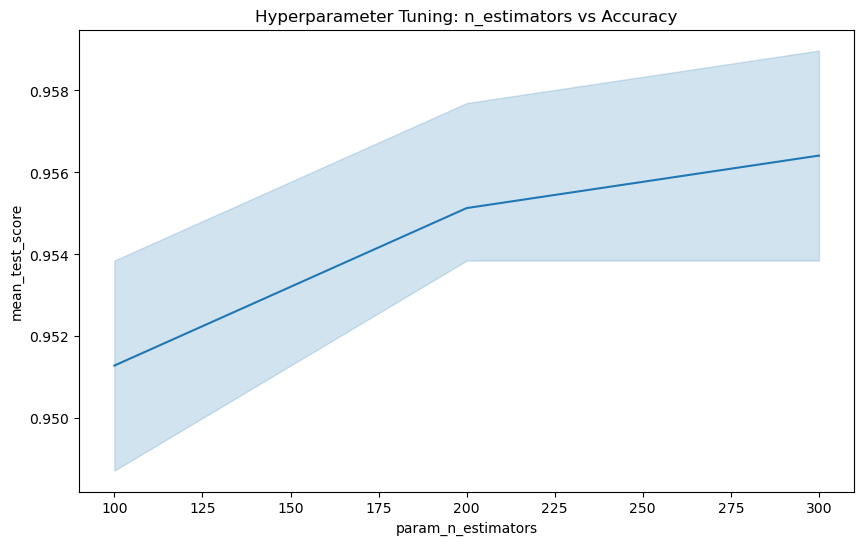

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=results)
plt.title('Hyperparameter Tuning: n_estimators vs Accuracy')
plt.show()